# Data Importation

In [119]:
%reset
import pandas as pd

otu_table = pd.read_csv("/data/namlhs/gmrepo/data"
                        "/modelling/absolute_count_raw.csv",
                        sep='\s+')

tax_table = pd.read_csv("/data/namlhs/gmrepo/data"
                        "/modelling/tax_table.csv",
                        sep=',')

meta_df = pd.read_csv("/data/namlhs/gmrepo/data"
                 "/modelling/total.csv",
                 index_col= 0)

# Data Wrangling

In [120]:
print(otu_table.head())

otu_table.set_index('query_name', inplace = True)
print(otu_table.head())

df =  meta_df[meta_df['associated phenotype'] != 'D000236']

  query_name  GCA_000007325.1  GCA_000020605.1  GCA_000154345.1  \
0  DRR127491                0              533                0   
1  DRR127507                0                0                0   
2  DRR127509                0              273                0   
3  DRR127514                0                0                0   
4  DRR127515                0              226              279   

   GCA_000155435.1  GCA_000158655.1  GCA_000166735.2  GCA_000182945.1  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   GCA_000242235.1  GCA_000283635.1  ...  GCF_902460355.1  GCF_902460545.1  \
0                0                0  ...                0                0   
1 

In [121]:
#relative abundance
otu_rel_table = (otu_table.T/otu_table.sum(axis=1)).T
otu_rel_table.sum(axis=1)

# pick first 50 ASVs only
otu_fil = otu_rel_table.iloc[: , :51]

otu_fil.index = otu_fil.index.str.replace('_', '.')

otu_fil.index.name = 'run_id'

In [122]:
#check the data sparsity
sparse = df.isnull().sum()/len(df)
display(sparse)

sparse_filtered = sparse[sparse < 0.2]

# Display the filtered Series
print(sparse_filtered)

#keep only column in sparse_filtered
df_filtered = df.loc[:, sparse_filtered.index]
df_filtered = df_filtered.set_index('run ID')
display(df_filtered)

run ID                  0.000000
experiment type         0.000000
instrument model        0.000000
host age                0.021254
sex                     0.413036
BMI                     0.043925
country                 0.000000
associated phenotype    0.000000
QC status               0.295430
dtype: float64

run ID                  0.000000
experiment type         0.000000
instrument model        0.000000
host age                0.021254
BMI                     0.043925
country                 0.000000
associated phenotype    0.000000
dtype: float64


,experiment type,instrument model,host age,BMI,country,associated phenotype
run ID,,,,,,
ERR478958,Metagenomics,Illumina,72.0,25.0,France,D006262
ERR478959,Metagenomics,Illumina,72.0,25.0,France,D006262
ERR478960,Metagenomics,Illumina,72.0,25.0,France,D006262
ERR478961,Metagenomics,Illumina,72.0,25.0,France,D006262
ERR478962,Metagenomics,Illumina,53.0,32.0,France,D006262
...,...,...,...,...,...,...
ERR1293933,Metagenomics,Illumina,62.0,25.8,USA,D006262
ERR1293934,Metagenomics,Illumina,84.0,23.5,USA,D015179
ERR1293935,Metagenomics,Illumina,84.0,23.5,USA,D015179


In [123]:
df_filtered.rename(columns={'associated phenotype': 'associated_phenotype'}, inplace=True)
df_crc = df_filtered[['associated_phenotype']].copy()


df_crc.index.name = 'run_id'

len(df_crc)
print(otu_fil.head())


           GCA_000007325.1  GCA_000020605.1  GCA_000154345.1  GCA_000155435.1  \
run_id                                                                          
DRR127491              0.0         0.086879         0.000000              0.0   
DRR127507              0.0         0.000000         0.000000              0.0   
DRR127509              0.0         0.008106         0.000000              0.0   
DRR127514              0.0         0.000000         0.000000              0.0   
DRR127515              0.0         0.003723         0.004596              0.0   

           GCA_000158655.1  GCA_000166735.2  GCA_000182945.1  GCA_000242235.1  \
run_id                                                                          
DRR127491              0.0              0.0              0.0              0.0   
DRR127507              0.0              0.0              0.0              0.0   
DRR127509              0.0              0.0              0.0              0.0   
DRR127514              0.0 

In [124]:
#merge first 50 ASVs relative abundance
match_df = pd.merge(df_crc, otu_fil, left_index=True, right_index=True)

df_cor = match_df.iloc[:, 1:].corr(method='kendall')
df_pairs = df_cor.unstack()

# print(df_pairs)
sorted_pairs = df_pairs.sort_values(kind='quicksort')
remove_pairs = sorted_pairs[(abs(sorted_pairs) >= 0.5) & (sorted_pairs != 1)]

display(remove_pairs)

Series([], dtype: float64)

In [125]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

X = match_df.drop(columns ='associated_phenotype')

y = match_df.associated_phenotype
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale
scaler = StandardScaler()
scaler.fit(X_train)

X_scale = scaler.transform(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logreg = LogisticRegression(random_state=777, 
                            max_iter= 100000, 
                            class_weight= 'balanced',
                            penalty="elasticnet", 
                            solver="saga",
                            C=1000,
                            l1_ratio=0.15,
                            )

lr_train = logreg.fit(X_train, y_train)
y_pred = lr_train.predict(X_test)

,factors,coef
6,GCA_000182945.1,2.531592
0,GCA_000007325.1,2.097326
22,GCA_000431275.1,1.743949
25,GCA_000431495.1,0.474552
12,GCA_000383295.1,0.386414
2,GCA_000154345.1,0.379173
46,GCA_000432735.1,0.322011
27,GCA_000431535.1,0.279053
28,GCA_000431775.1,0.276234
38,GCA_000432275.1,0.240154


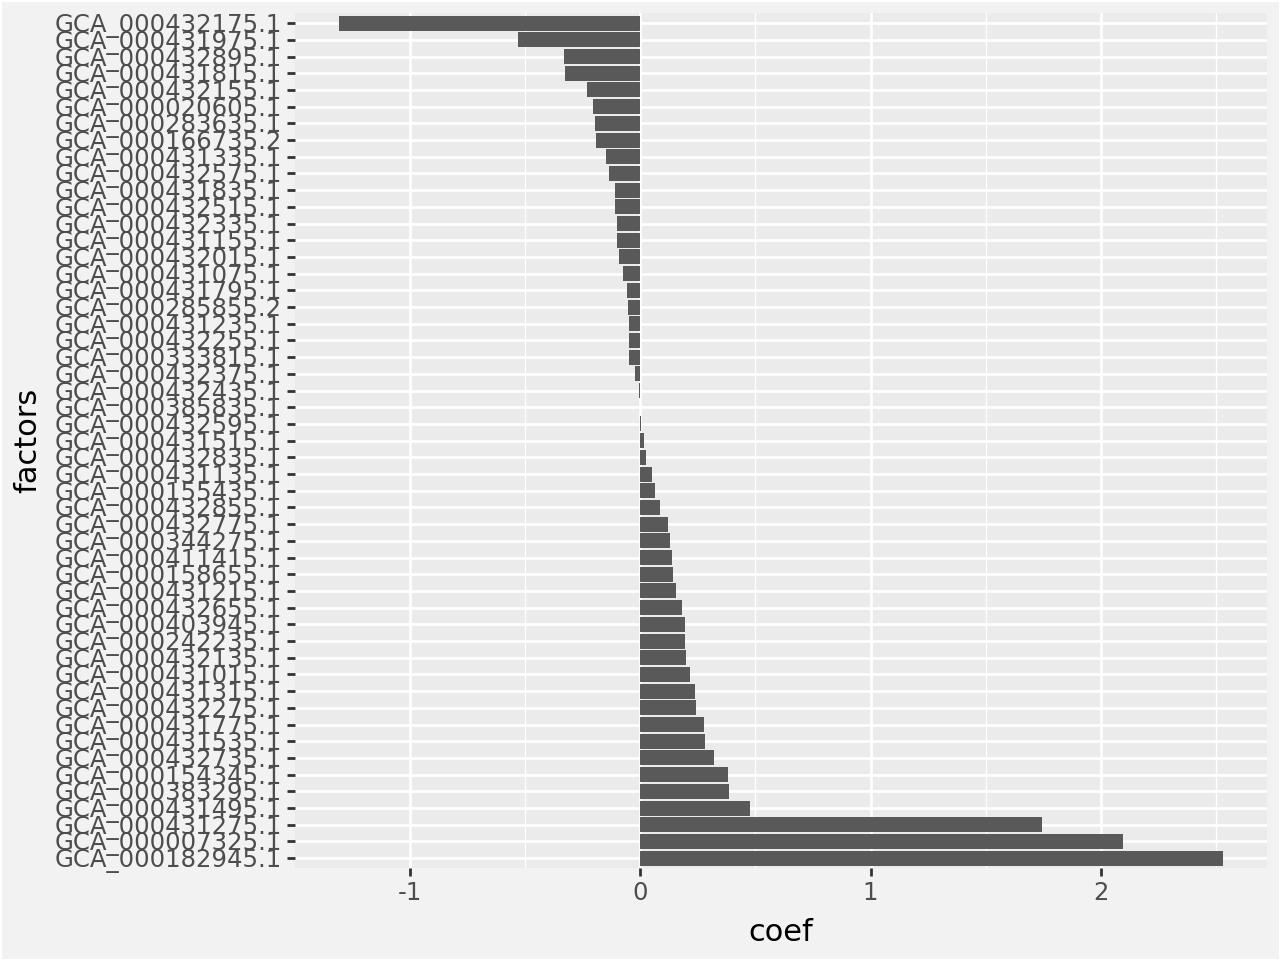

In [127]:
import plotnine as p9

# get the feature coefficients and feature names
feature_coef = lr_train.coef_[0]
feature_names = X.columns.tolist() # assuming your input data is a pandas DataFrame

coef_df = pd.DataFrame({'factors':feature_names, 'coef':feature_coef}).sort_values(ascending=False, by="coef")
display(coef_df)

#sorted factor
factor_list = coef_df['factors']

(
    p9.ggplot(coef_df, p9.aes(x = 'factors', y = 'coef')) +
    p9.geom_col() +
    p9.scale_x_discrete(limits = factor_list) +
    p9.coord_flip()
)

In [132]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# Visualize
# import required modules
import numpy as np
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.rcParams['figure.facecolor'] = '#f2f2f2'

In [130]:
from sklearn.metrics import classification_report
target_names = ['Healthy', 'CRC']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.55      0.65      0.60       249
         CRC       0.63      0.53      0.58       281

    accuracy                           0.59       530
   macro avg       0.59      0.59      0.59       530
weighted avg       0.60      0.59      0.59       530



In [131]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

ValueError: y_true takes value in {'D006262', 'D015179'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.